# Change Point Detection

This notebook is designed to perform bayesian change point detection on each individual token.
This method provides probability estimates that a changepoint occurred at a given time point.
There may be a problem with detecting changes at the extreme ends of the time series but inconclusive at the moment.

In [1]:
from functools import partial
from pathlib import Path
import re

from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
import tqdm

import bayesian_changepoint_detection.offline_changepoint_detection as offcd

Use scipy logsumexp().


# Grab Word Frequencies

In [2]:
if not Path("output/all_tok_frequencies.tsv").exists():
    data = []
    for model in tqdm.tqdm(
        sorted(
            list(Path("../multi_model_experiment/output/models").rglob("*/*_0.model"))
        )
    ):
        wv_model = Word2Vec.load(str(model))
        word_freq_df = pd.DataFrame.from_records(
            [
                {
                    "tok": tok,
                    "word_count": wv_model.wv.get_vecattr(tok, "count"),
                    "year": re.search(r"(\d+)_0", str(model)).group(1),
                }
                for tok in wv_model.wv.index_to_key
            ]
        )
        total_count = word_freq_df.word_count.sum()
        word_freq_df = word_freq_df >> ply.define(frequency=f"word_count/{total_count}")
        data.append(word_freq_df)

100%|██████████| 21/21 [04:44<00:00, 13.53s/it]


In [3]:
if not Path("output/all_tok_frequencies.tsv.xz").exists():
    all_word_freq_df = pd.concat(data)
    all_word_freq_df.dropna().to_csv(
        "output/all_tok_frequencies.tsv.xz", sep="\t", index=False, compression="xz"
    )
else:
    all_word_freq_df = (
        pd.read_csv("output/all_tok_frequencies.tsv.xz", sep="\t")
        .dropna()
        .astype({"year": int})
    )
all_word_freq_df

,tok,word_count,year,frequency
0,,87283.0,2000,8.850373e-02
1,mouse,299.0,2000,3.031818e-04
2,homologue,43.0,2000,4.360139e-05
3,of,35677.0,2000,3.617598e-02
4,the,38877.0,2000,3.942073e-02
...,...,...,...,...
9158541,1-ethynyladamantanes,1.0,2020,1.285818e-08
9158542,1800-fold,1.0,2020,1.285818e-08
9158543,foveally,1.0,2020,1.285818e-08
9158544,0.45x:12.79,1.0,2020,1.285818e-08


In [4]:
subsetted_tokens = pd.read_csv(
    "../multi_model_experiment/output/subsetted_tokens.tsv", sep="\t"
)
token_filter_list = subsetted_tokens.tok.tolist()
subsetted_tokens.head()

,tok
0,united
1,combining
2,purinergic
3,decomposition
4,60.0


## Calculate percent change for frequency

In [5]:
all_word_pct_change_df = (
    all_word_freq_df
    >> ply.query(f"tok in {token_filter_list}")
    >> ply.group_by("tok")
    >> ply.arrange("year")
    >> ply.define(
        freq_pct_change="frequency.pct_change()",
        frequency_ratio=lambda x: x.frequency / x.shift(1).frequency,
    )
    >> ply.ungroup()
    >> ply.call(".dropna")
    >> ply.define(year=lambda x: x["year"].apply(lambda y: f"{int(y)-1}-{y}"))
)
all_word_pct_change_df.head()

,tok,word_count,year,frequency,freq_pct_change,frequency_ratio
57757,organised,7.0,2000-2001,0.000006,0.952062,1.952062
57756,observers,3.0,2000-2001,0.000003,-0.686276,0.313724
57750,compensate,8.0,2000-2001,0.000007,0.673196,1.673196
57723,stems,4.0,2000-2001,0.000003,0.115464,1.115464
57746,forebrain,6.0,2000-2001,0.000005,0.003918,1.003918


# Grab semantic change values

In [6]:
distance_files = list(
    Path("../multi_model_experiment/output/combined_inter_intra_distances").rglob(
        "saved_*_distance.tsv"
    )
)
print(len(distance_files))

20


In [7]:
year_distance_map = {
    re.search(r"\d+", str(year_file)).group(0): (pd.read_csv(str(year_file), sep="\t"))
    for year_file in tqdm.tqdm(distance_files)
}

100%|██████████| 20/20 [00:01<00:00, 12.08it/s]


In [8]:
full_token_set_df = pd.concat(
    [
        year_distance_map[year] >> ply.query("year_2-year_1 == 1")
        for year in tqdm.tqdm(year_distance_map)
    ]
)
print(full_token_set_df.shape)
full_token_set_df.head()

100%|██████████| 20/20 [00:00<00:00, 395.83it/s]

(390810, 7)


,tok,original_global_distance,global_distance_qst,local_distance_qst,ratio_metric,year_1,year_2
0,poly(adp,0.211844,0.522492,0.696891,1.094208,2009,2010
1,partners,0.159972,0.491531,0.625901,0.966688,2009,2010
2,permeation,0.280244,0.565166,0.694604,1.299729,2009,2010
3,137,0.385017,0.592415,0.782952,1.453473,2009,2010
4,sixty,0.170093,0.520045,0.578388,1.083528,2009,2010


# Combine both information

Using an idea similar to SCAF \[[1](https://doi.org/10.1007/s00799-019-00271-6)\], I'm combining the global qst metric with the percent change in frequency.
SCAF uses percent change for both metrics; however, the caveat is that their method loses information for the first two timepoints.
In my case given that global_distance_qst is a metric that's bound between 0 and 1 frequency percent change can be used directly.
By combining these two terms I can use this metric as a means to estimate change and allow for bayesian changepoint detection to calculate the probability of a timepoint change.

In [9]:
merged_frequency_df = (
    full_token_set_df
    >> ply_tdy.unite("year", "year_1", "year_2", sep="-")
    >> ply.inner_join(all_word_pct_change_df, on=["tok", "year"])
    >> ply.rename(year_pair="year")
    >> ply.select(
        "tok",
        "original_global_distance",
        "global_distance_qst",
        "ratio_metric",
        "year_pair",
        "frequency",
        "freq_pct_change",
        "frequency_ratio",
    )
)
merged_frequency_df

,tok,original_global_distance,global_distance_qst,ratio_metric,year_pair,frequency,freq_pct_change,frequency_ratio
0,poly(adp,0.211844,0.522492,1.094208,2009-2010,3.340596e-06,-0.156690,0.843310
1,partners,0.159972,0.491531,0.966688,2009-2010,4.281238e-05,-0.046123,0.953877
2,permeation,0.280244,0.565166,1.299729,2009-2010,5.567661e-06,-0.017940,0.982060
3,137,0.385017,0.592415,1.453473,2009-2010,4.717860e-06,0.180164,1.180164
4,sixty,0.170093,0.520045,1.083528,2009-2010,2.101059e-05,0.187133,1.187133
...,...,...,...,...,...,...,...,...
298835,residences,0.390813,0.557452,1.259640,2014-2015,9.709601e-07,0.072999,1.072999
298836,polyproteins,0.654729,0.556530,1.254943,2014-2015,2.703940e-07,0.387331,1.387331
298837,mimicking,0.218953,0.558827,1.266683,2014-2015,1.356886e-05,0.043536,1.043536
298838,synergistic,0.113028,0.490899,0.964248,2014-2015,2.541703e-05,0.028000,1.028000


In [10]:
change_metric_df = (
    merged_frequency_df
    >> ply.group_by("tok")
    >> ply.arrange("year_pair")
    >> ply.define(
        change_metric_qst="global_distance_qst + freq_pct_change",
        change_metric_ratio="ratio_metric + frequency_ratio",
    )
    >> ply.ungroup()
)
change_metric_df

,tok,original_global_distance,global_distance_qst,ratio_metric,year_pair,frequency,freq_pct_change,frequency_ratio,change_metric_qst,change_metric_ratio
52296,hmsh2,0.220541,0.602066,1.512979,2000-2001,0.000008,-0.070446,0.929554,0.531619,2.442533
54781,lock,0.961701,0.728451,2.682575,2000-2001,0.000002,0.673196,1.673196,1.401647,4.355772
54782,urinary,0.289514,0.773856,3.421954,2000-2001,0.000093,0.394330,1.394330,1.168186,4.816284
54783,swimming,0.711984,0.657287,1.917889,2000-2001,0.000005,4.019589,5.019589,4.676875,6.937478
54784,uncover,0.582078,0.670746,2.037169,2000-2001,0.000008,7.365982,8.365982,8.036727,10.403150
...,...,...,...,...,...,...,...,...,...,...
99611,factorial,0.175588,0.465320,0.870279,2019-2020,0.000008,0.109293,1.109293,0.574614,1.979572
99610,epsilon,0.360522,0.554700,1.245676,2019-2020,0.000005,-0.076923,0.923077,0.477777,2.168753
99609,u87,0.237114,0.469929,0.886539,2019-2020,0.000003,-0.172239,0.827761,0.297689,1.714299
99621,minimizing,0.162147,0.530061,1.127937,2019-2020,0.000009,0.069525,1.069525,0.599587,2.197463


# Change point detection

Use Semantic Change Analysis with Frequency (SCAF) to perform bayesian change point detection.

In [11]:
if not Path("output/bayesian_changepoint_data.tsv", sep="\t").exists():
    change_point_results = []
    for tok, tok_series_df in tqdm.tqdm(change_metric_df.groupby("tok")):

        change_metric_ratio = np.insert(
            tok_series_df >> ply.pull("change_metric_ratio"), 0, 0
        )
        Q, P, Pcp = offcd.offline_changepoint_detection(
            change_metric_ratio,
            partial(offcd.const_prior, l=(len(change_metric_ratio) + 1)),
            offcd.gaussian_obs_log_likelihood,
            truncate=-40,
        )
        estimated_changepoint_probability = np.exp(Pcp).sum(0)

        change_point_results.append(
            pd.DataFrame.from_dict(
                {
                    "tok": [tok] * len(estimated_changepoint_probability),
                    "changepoint_prob": estimated_changepoint_probability,
                    "year_pair": (
                        tok_series_df
                        >> ply.select("year_pair")
                        >> ply.pull("year_pair")
                    ),
                }
            )
        )

100%|██████████| 14942/14942 [05:11<00:00, 47.91it/s]


In [12]:
if not Path("output/bayesian_changepoint_data.tsv", sep="\t").exists():
    change_point_df = pd.concat(change_point_results)
    change_point_df.to_csv(
        "output/bayesian_changepoint_data.tsv", sep="\t", index=False
    )
else:
    change_point_df = pd.read_csv("output/bayesian_changepoint_data.tsv", sep="\t")
change_point_df.head()

,tok,changepoint_prob,year_pair
0,!,0.053777,2000-2001
1,!,0.031161,2001-2002
2,!,0.018131,2002-2003
3,!,0.006150,2003-2004
4,!,0.008987,2004-2005


In [13]:
(change_point_df >> ply.arrange("-changepoint_prob") >> ply.slice_rows(30))

,tok,changepoint_prob,year_pair
18,coronavirus,0.981855,2018-2019
6,canals,0.965532,2006-2007
18,pandemic,0.964905,2018-2019
5,e.coli,0.956191,2005-2006
8,title,0.949711,2008-2009
18,copyright,0.944147,2018-2019
8,galectin-1,0.940742,2008-2009
6,breastfeeding,0.938877,2006-2007
3,granulosa,0.938544,2003-2004
18,zu,0.931460,2018-2019


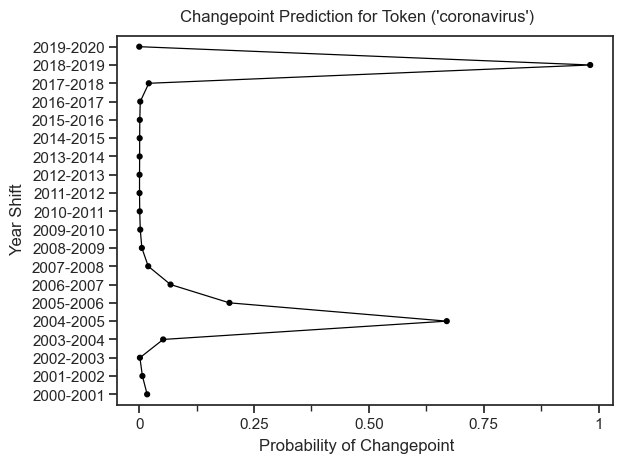

<ggplot: (-9223363249510952455)>

In [14]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='coronavirus'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="Year Shift",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('coronavirus')",
    )
)

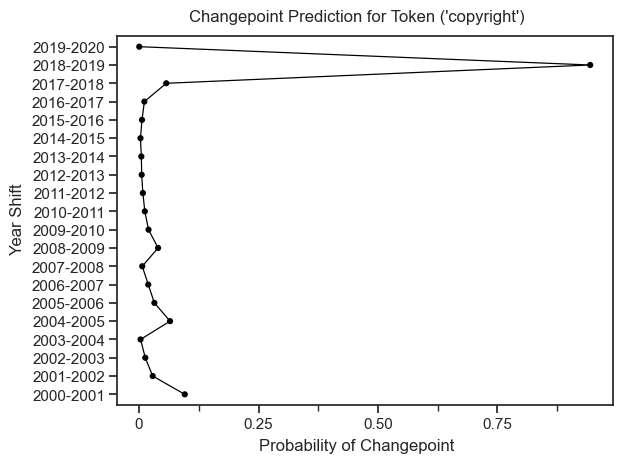

<ggplot: (8787333973501)>

In [15]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='copyright'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="Year Shift",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('copyright')",
    )
)

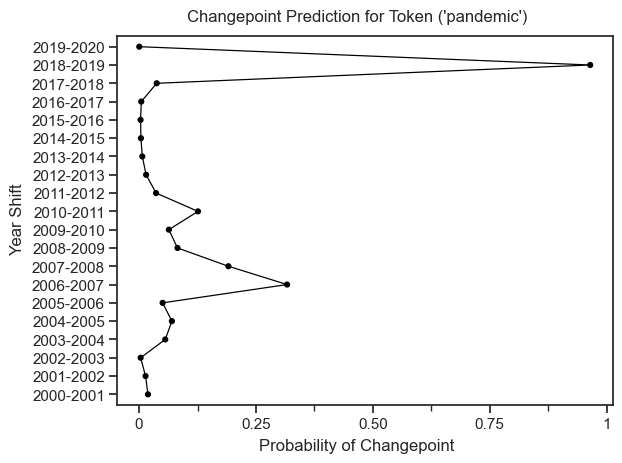

<ggplot: (8787333970061)>

In [16]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='pandemic'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="Year Shift",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('pandemic')",
    )
)

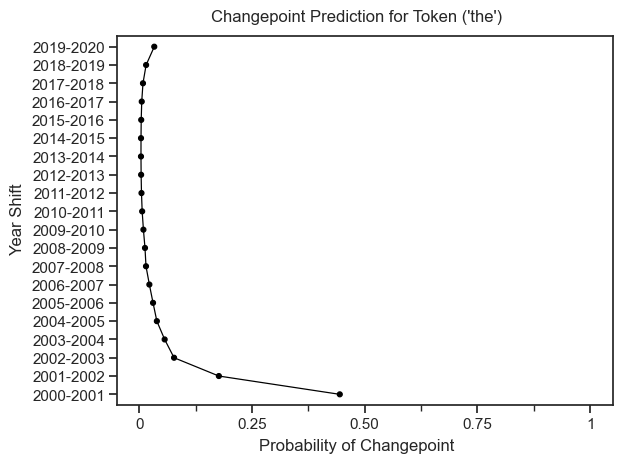

<ggplot: (-9223363249513411598)>

In [17]:
(
    p9.ggplot(change_point_df >> ply.query("tok=='the'"))
    + p9.aes(x="year_pair", y="changepoint_prob", group=0)
    + p9.geom_point()
    + p9.geom_line()
    + p9.coord_flip()
    + p9.theme_seaborn("white")
    + p9.labs(
        x="Year Shift",
        y="Probability of Changepoint",
        title="Changepoint Prediction for Token ('the')",
    )
    + p9.scale_y_continuous(limits=[0, 1])
)

# Take Home Points

1. Bayesian change point detection provides insight on the specific year period a semantic change point may have occurred.
2. Best positive result is pandemic which underwent a focus shift from bird flu and influenza to coronavirus.
3. Follow up analysis which will appear in the next notebook will involve looking at the top X token neighbors to the query word. By doing that one can estimate which kind of shift a word has undergone.